# XYMOL Tutorial

In this tutorial, we are going to walk throught a fairly simple machine learning task and use XYMOL to visualize and explain our prediction. 

## Dependency Installation

First, let's install and import some required dependencies for our task.

In [1]:
!pip install PyTDC xgboost deepchem &> /dev/null
!pip install git+https://github.com/smu-tao-group/xymol.git &> /dev/null

In [2]:
from xgboost import XGBRegressor
from deepchem import deepchem
from tdc.benchmark_group import admet_group
from tdc import Evaluator
from xymol import XYMOL

## Data Loading and Featurization

We definitely need some data to perform a machine learning task. We will use TDC ADMET group, and specifically, we are going to predict cell effective permeability (Caco-2). 

For each SMILES representation, we use circular fingerprints for featurization, to turn SMILES into numerical features. 

In [3]:
group = admet_group(path='data/')
benchmark = group.get("caco2_wang")
train_val, test = benchmark['train_val'], benchmark['test']

100%|██████████| 1.47M/1.47M [00:01<00:00, 1.08MiB/s]
Extracting zip file...
Done!


In [4]:
featurizer = deepchem.feat.CircularFingerprint()
X_train_val = featurizer.featurize(train_val.iloc[:, 1].to_list())
X_test = featurizer.featurize(test.iloc[:, 1].to_list())

y_train_val = train_val.iloc[:, 2].to_list()
y_test = test.iloc[:, 2].to_list()

## Model Training and Evaluation

Let's train a fast while powerful machine learning model, XGBoost. For demonstration purpose, there is no parameter finetuning. 

In [5]:
xgb = XGBRegressor(
    n_estimators=500, max_depth=6,
    tree_method="gpu_hist", objective="reg:squarederror"
)
xgb.fit(X_train_val, y_train_val)
y_pred = xgb.predict(X_test)

According to the leaderboard metric, we use mean absolute error (MAE) to evaluate the performance. It turned out that we have a MAE of 0.322. This is actually quite good when being compared with other models!

In [6]:
evaluator = Evaluator(name = 'MAE')
print("MAE error: ", evaluator(y_test, y_pred))

MAE error:  0.3217974767026796


## XYMOL Visualization

Finally, let's take the first testing data and use the trained model and featurizer above to explain our model. What XYMOL can do is to drop one atom, each at a time, and calculate the prediction difference, which would be the importance/impact of this atom.  

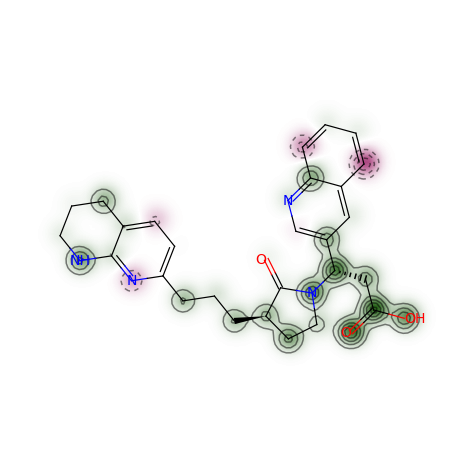

In [7]:
smiles = test.iloc[0, 1]

xymol = XYMOL(smiles)
xymol.create_map(featurizer, xgb)

Blue color represents dropping this atom leads to an increase in prediction, and vise versa. 